In [1]:
import pandas as pd
import numpy as np
import os
import sys
from profilehooks import profile
np.seterr(invalid='raise')



data_path = '../data/RESULTS_EUROVIS2015.csv'
folder_path = "../data/EUROVIS_new/"

os.getcwd()



'/Users/morarica/Developer/SepMe/Jupyters'

In [2]:

from copy import copy
from scipy.spatial import Delaunay, ConvexHull
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from scipy.spatial.distance import euclidean, cdist, pdist, squareform
import itertools
from collections import Counter
import bisect
from functools import wraps
from time import time
import math
from scipy import stats
import plotly.express as px
import random
import seaborn as sns

np.seterr(invalid='raise')



data_path = '../data/RESULTS_EUROVIS2015.csv'
folder_path = "../data/EUROVIS_new/"

os.getcwd()



def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r took: %2.4f sec' % \
          (f.__name__, te-ts))

        return result
    return wrap


def timeit(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r took: %2.4f sec' % \
          (f.__name__, te-ts))

        return result
    return wrap


In [3]:
f = plt.figure(figsize=(20,20))

# test Delauney
graph_del = get_delaunay(df)
plt.subplot(421, figure = f, title = 'Deulaunay')
nx.draw(graph_del, pointIDXY, node_size=25)

NameError: name 'get_delaunay' is not defined

<Figure size 1440x1440 with 0 Axes>

In [4]:
df = pd.read_csv(data_path)
#print(df.head())

for i, file in enumerate(df.fileName):
    file_name = folder_path + file.split('.csv')[0] + '_cls' + str(df.classNum[i]) + '.csv'
    try:
        sample_df = pd.read_csv(file_name, names=['x','y','class'])
        #print(sample_df.head(1))
    except FileNotFoundError:
        print('File \'' + file +'\' does not exist.')

sample_df.head()
df = sample_df

File 'AUCBA' does not exist.


In [5]:
df.tail()

,x,y,class
187,878,274,0
188,882,322,0
189,896,227,0
190,900,294,0
191,904,260,0


# Construct Neighbourhood Graphs

In [13]:
df = sample_df
def attr_difference(G, H):
    """Returns a new graph that contains the edges with attributes that exist in G but not in H.

    The node sets of H and G must be the same.

    Parameters
    ----------
    G,H : graph
       A NetworkX graph.  G and H must have the same node sets.

    Returns
    -------
    D : A new graph with the same type as G.
    """
    # create new graph
    if not G.is_multigraph() == H.is_multigraph():
        raise nx.NetworkXError('G and H must both be graphs or multigraphs.')
    R = nx.create_empty_copy(G)

    if set(G) != set(H):
        raise nx.NetworkXError("Node sets of graphs not equal")

    if G.is_multigraph():
        edges = G.edges(keys=True)
    else:
        edges = G.edges(data = True)
        #print(edges)
    for e in edges:
        if not H.has_edge(*e[:2]):
            #print(e)
            R.add_edge(*e[:2], weight = e[2]['weight'])
    return R

@timeit
def add_node_attr(graph, df, color=False):
    # add node position and class as attributes
    colors = []
    for n in graph.nodes():
        graph.node[n]['pos'] = list(df.loc[n,['x','y']])
        graph.node[n]['class'] = int(df.loc[n,['class']])
        if color:
            if int(df.loc[n,['class']]):
                colors.append('blue')
            else:
                colors.append('red')
    
    if color:
        return (graph, colors)
    else:
        return graph

@timeit
def get_delaunay(df, with_tri = False):
    graph = nx.Graph()
    tri = Delaunay(df[['x','y']])

    edges = set()
    for n in range(tri.nsimplex):
        edge = sorted([tri.simplices[n,0], tri.simplices[n,1]])
        edges.add((edge[0], edge[1], euclidean((df.loc[tri.simplices[n,0],['x','y']]), (df.loc[tri.simplices[n,1],['x','y']]))))
        edge = sorted([tri.simplices[n,0], tri.simplices[n,2]])
        edges.add((edge[0], edge[1], euclidean((df.loc[tri.simplices[n,0],['x','y']]), (df.loc[tri.simplices[n,2],['x','y']]))))
        edge = sorted([tri.simplices[n,1], tri.simplices[n,2]])
        edges.add((edge[0], edge[1], euclidean((df.loc[tri.simplices[n,1],['x','y']]), (df.loc[tri.simplices[n,2],['x','y']]))))

    graph.add_weighted_edges_from(edges)

    if with_tri:
        tri.close()
        return graph, tri
    
    return graph

@timeit
def get_convex_hull(df):
    graph = nx.Graph()
    hull = ConvexHull(df[['x','y']])
    
    weighted_edges = []
    for edge in hull.simplices:
        e = (edge[0], edge[1], euclidean(df.loc[edge[0], ['x','y']], df.loc[edge[1], ['x','y']]))
        weighted_edges.append(e)
    
    graph.add_weighted_edges_from(weighted_edges)
    return graph

#uses Delaunay graph
@timeit
def get_mst(graph):
    return nx.minimum_spanning_tree(graph)

@timeit
def get_knntree(df, n=1):
    X = df[['x','y']]
    A = kneighbors_graph(X, n+1, mode='distance', include_self=True)
    A.toarray()
    graph = nx.from_numpy_matrix(A.toarray(), create_using=nx.DiGraph)
    #nx.draw(graph, pointIDXY, node_size=25)
    return graph

@timeit
def get_balltree(df, radius=30):
    X = df[['x','y']]
    A = radius_neighbors_graph(X, radius, mode='distance', include_self=True)
    A.toarray()
    graph = nx.from_numpy_matrix(A.toarray())
    #nx.draw(graph, pointIDXY, node_size=25)
    return graph

@timeit
def get_rng(df, graph_del, graph_mst):
    # get all edge who are in DT nad not in EMST
    candidate_graph  = attr_difference(graph_del, graph_mst)
    candidate_graph = add_node_attr(candidate_graph, df)

    remove_list = []
    for edge in candidate_graph.edges(data = True):
        edge_weight = edge[2]['weight'] 
        for possible_blocker in candidate_graph.nodes(data = True):
            pos = possible_blocker[1]['pos']
            dist_n0 = euclidean(pos, candidate_graph.nodes(data=True)[edge[0]]['pos'])
            dist_n1 = euclidean(pos, candidate_graph.nodes(data=True)[edge[1]]['pos'])
            if dist_n0 < edge_weight and dist_n1 < edge_weight:
                remove_list.append(edge)
                
    graph_rng = graph_del.copy()
    graph_rng.remove_edges_from(remove_list)
    
    print(len(graph_rng.edges(data=True)))
    print(len(graph_del.edges(data=True)))
    
    return graph_rng

@timeit
def get_kncg(df, K=4):
    graph = get_knntree(df,1)
    for node_a, row in df.iterrows():
        node_a_coord = list(row[:2])
        ncns = []
        ncn_coords = []

        for nn in graph.neighbors(node_a):
            ncns.append(nn)
            ncn_coords.append(list(df.loc[nn,['x','y']]))

        #print(ncns)
        for k in range(2,K+1):
            dist = -1
            chosen_one = 0
            for node_b, row_b in df.iterrows():
                if node_b in ncns + [node_a]:
                    continue
                else:
                    node_b_coord = list(row_b[:2])
                    centroid = np.mean(ncn_coords + [node_b_coord], axis = 0)
                    #print(centroid)
                    cdist = euclidean(node_a_coord, centroid)

                    if dist == -1 or cdist<dist:
                        chosen_one = node_b
                        chosen_one_coord = node_b_coord
                        dist = cdist
            #print(dist)
            ncns.append(chosen_one)    
            graph.add_edge(node_a, chosen_one, weight = euclidean(node_a_coord, chosen_one_coord))
    return graph


@timeit
def get_gong(df, y=0):
    graph = nx.DiGraph() 
    graph.add_nodes_from(df.iterrows())
    dists = pdist(df[['x','y']]) 
    dists = squareform(dists)
    y_dists = (1-y)*dists
    
    for node_a, row_a in df.iterrows():
        node_a_coord = list(row_a[:2]) # O(dn)
        dist_idx = np.argsort(dists[node_a]) # O(nlog n)
        for node_b in dist_idx:
            if node_a == node_b:
                continue
                
            node_b_coord = list(df.loc[node_b, ['x','y']])

            d_i = y_dists[node_a][node_b]
            first_greater = bisect.bisect_left(dists[node_a][dist_idx], d_i)
            
            b_is_GONG = True

            for node_j in dist_idx[:first_greater]:
                if node_a == node_j:
                    continue
                    
                d_j = y_dists[node_a][node_j]
                
                if d_j < d_i:
                    b_is_GONG = False
                    break # node_j could be a GONG

            if b_is_GONG:
                graph.add_edge(node_a, node_b, weight = dists[node_a][node_b])
    return graph

@timeit
def get_as(df, alpha=0.05):
    graph = get_delaunay(df)  
    del_edges = []
    for edge in graph.edges(data =True):
        distance = edge[2]['weight']
        if distance > 2 / alpha:
            del_edges.append(edge)
        else:
            pass

    graph.remove_edges_from(del_edges)
    return graph

@profile
@timeit
def get_CBSG(df, beta = 0,  dists = None):

    graph = nx.Graph() 
    graph.add_nodes_from(df.iterrows())

    if dists==None:
        dists = pdist(df[['x','y']]) 
        dists = squareform(dists)

    angleMax = np.pi*0.5*(1+beta)

    for node_a, row_a in df[['x','y']].iterrows():
        print(node_a)
        for node_b, row_b in df[['x','y']].iterrows():
            if node_a == node_b:
                continue

            novois = 0
            for node_k, row_k in df[['x','y']].iterrows():
                if node_k == node_b or node_k == node_a:
                    continue

                ak = np.array(row_a - row_k)
                bk = np.array(row_b - row_k)

                try:
                    cosine_angle = np.dot(ak, bk) / (dists[node_a, node_k] * dists[node_b, node_k])
                    if cosine_angle>1 or cosine_angle<-1:
                        novois = 1
                        break
                    
                    angle = np.arccos(cosine_angle)
                    
                except:
                    novois = 1
                    angle = angleMax + 1
                    break
                    
                
                #break
                if angle > angleMax:
                    novois = 1
                    break
            #break
            if novois == 0:
                graph.add_edge(node_a, node_b, weight = dists[node_a][node_b])
        #break
    return graph




func:'get_delaunay' took: 1.0041 sec
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
func:'get_CBSG' took: 1.7911 sec


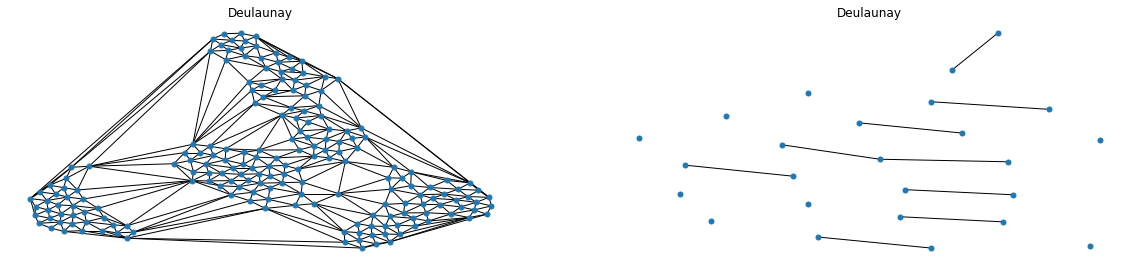

In [18]:
pointIDXY = dict(zip(range(len(df[['x','y']])), np.array(df[['x','y']])))

f = plt.figure(figsize=(20,20))

# test Delauney
graph_del = get_delaunay(df)
plt.subplot(421, figure = f, title = 'Deulaunay')
nx.draw(graph_del, pointIDXY, node_size=25)


# test Delauney
graph_del = get_CBSG(df[0:25], beta = -0.5,  dists = None)
plt.subplot(422, figure = f, title = 'Deulaunay')
nx.draw(graph_del, pointIDXY, node_size=25)

# # test EMST
# graph_mst = get_mst(graph_del)
# plt.subplot(422, figure = f, title = 'EMST')
# nx.draw(graph_mst, pointIDXY, node_size=25)




# # test KNNtree
# graph = get_knntree(df,3)
# plt.subplot(423, figure = f, title = 'KNNTree')
# nx.draw(graph, pointIDXY, node_size=25)

# # test KNCG
# graph_kncg = get_kncg(df, 3)
# plt.subplot(424, figure = f, title = 'KNCG')
# nx.draw(graph_kncg, pointIDXY, node_size=25)


# # test BallTree
# graph = get_balltree(df, 50)
# plt.subplot(425, figure = f, title = 'BallTree')
# nx.draw(graph, pointIDXY, node_size=25)


# # test Convex Hull (CH)
# graph_ch = get_convex_hull(df)
# plt.subplot(426, figure = f, title = 'CH')
# nx.draw(graph_ch, pointIDXY, node_size=25)


# # test GONG
# gong = get_gong(df, 0.3)
# plt.subplot(427, figure = f, title = 'GONG')
# nx.draw(gong, pointIDXY, node_size=25) 


# graph_rng = get_rng(df, graph_del, graph_mst)
# plt.subplot(428, figure = f, title = 'RNG')
# nx.draw(graph_rng, pointIDXY, node_size=25)

# plt.show()

func:'get_knntree' args:[] took: 0.0063 sec


/anaconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/anaconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



func:'get_knntree' args:[] took: 0.0025 sec
func:'get_kncg' args:[] took: 19.2255 sec


/anaconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/anaconda3/envs/SepMe/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



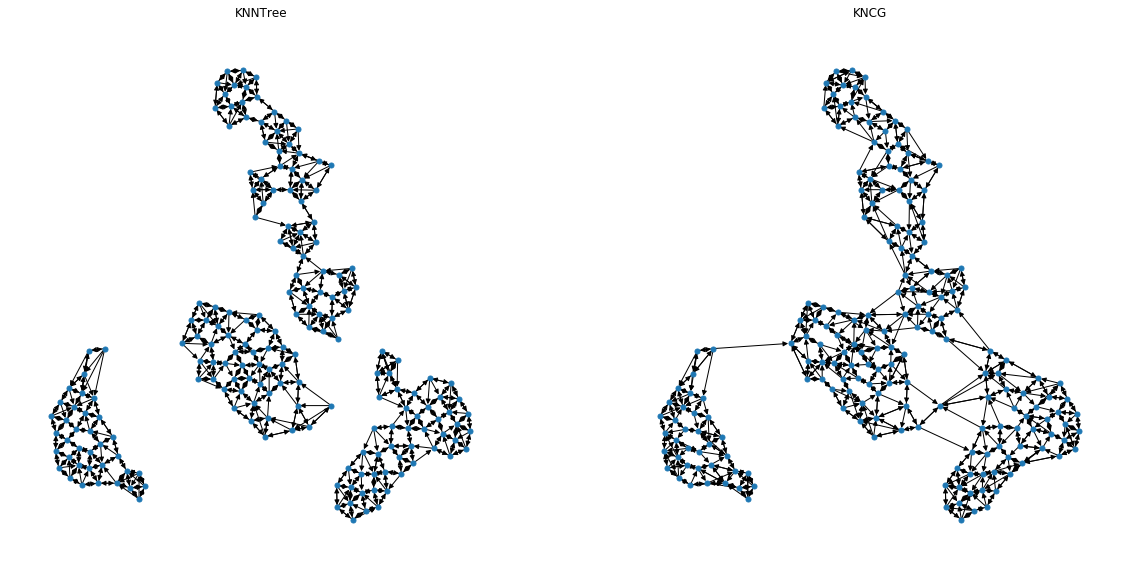

In [65]:
f = plt.figure(figsize=(20,10))
k = 4
pointIDXY = dict(zip(range(len(df[['x','y']])), np.array(df[['x','y']])))

# test KNNtree
graph_knn = get_knntree(df,k)
plt.subplot(121, figure = f, title = 'KNNTree')
nx.draw(graph_knn, pointIDXY, node_size=25)

# test KNCG
graph_kncg = get_kncg(df, k)
plt.subplot(122, figure = f, title = 'KNCG')
nx.draw(graph_kncg, pointIDXY, node_size=25)

# Class Purity

In [104]:
graph_knn = get_knntree(df,k)
graph_knn = add_node_attr(graph_knn, df)
graph_knn.nodes(data=True)

purity_type=['cp', 'ce', 'mv', 'wv']
aggregation_type=['target', 'all']
neighbours = {}

def get_vote(neighbours, pessimism = True, target_class = 1):
    first_mode = stats.mode(neighbours)
    nn = neighbours.copy()
    nn.remove(first_mode.mode[0]) #this removes the first occurence of the mode
    second_mode = stats.mode(nn)
    
    if first_mode.count[0] == second_mode.count[0]:
        # this means there's a tie and there are two modes
        # if the target class is either of these modes, watch out for pessimism
        if target_class == first_mode.mode[0]:
            return second_mode.mode[0] if pessimism else target_class
            
        if target_class == second_mode.mode[0]:
            return first_mode.mode[0] if pessimism else target_class
    
    # if there isn't a tie, or target class is not in tied modes
    return first_mode.mode[0]

@timeit
def neighbour_purity(graph, df, purity_type=['cp', 'ce', 'mv'], pessimism = True):
    # per datapoint results
    # we don't use networkx to store attributes in because it's slow and annoying
    node_scores = []
    
    classes = set(df['class'])
    number_of_classes = len(classes)
    cp = []
    ce = []
    mv = []
    wv = []
    
    for node in graph.nodes(data=True):
        neighbour_classes = list(df.loc[graph.neighbors(node[0]),'class'])
        amount_of_neighbours = len(neighbour_classes)
        
        self_class = node[1]['class']
        count_of_self = neighbour_classes.count(self_class)
        
        if 'cp' in purity_type:
            #node[1]['cp'] = count_of_self/len(neighbour_classes)
            cp.append(count_of_self/amount_of_neighbours)
    
        if 'ce' in purity_type:
            hi = 0
            
            for c in classes:
                if self_class == c:
                    qi = (count_of_self+1)/(amount_of_neighbours+1)
                else:
                    qi = neighbour_classes.count(c)/(amount_of_neighbours+1)
                    
                hi -= (qi*math.log(qi,number_of_classes) if qi!=0 else 0)
                            
            #node[1]['ce'] = hi
            ce.append(hi)
        
        if 'mv' in purity_type:
            vote = get_vote(neighbour_classes, pessimism, self_class)
            mv.append(vote)
            
        if 'wv' in purity_type:
            pass
    
    if len(cp)==len(df):
        df['cp'] = cp
    if len(ce)==len(df):
        df['ce'] = ce
    if len(mv)==len(df):
        df['mv'] = mv
    if len(wv)==len(df):
        df['wv'] = wv

    return df

@timeit
def total_neighbour_purity(df, graph, class_name = None, purity_type=['cp', 'ce', 'mv'],  pessimism = False):
    df = neighbour_purity(graph, df, purity_type, pessimism)
    stats = {}
    if class_name != None:
        for pp in purity_type:
            stats[pp] = np.mean(df[df['class']==class_name][pp])
    
    else: 
        for pp in purity_type:
            stats[pp] = np.mean(df.loc[:, pp])
    
    return stats

@timeit
def ltcc(graph, df):
    rem_edges = []
    for edge in graph_knn.edges():
        #print(edge)
        node_a = graph_knn.nodes(data=True)[edge[0]]['class']
        node_b = graph_knn.nodes(data=True)[edge[1]]['class']

        if node_a != node_b:
            rem_edges.append(edge)

    graph_knn.remove_edges_from(rem_edges)
    undir_graph_knn = graph_knn.to_undirected()
    undir_graph_knn = add_node_attr(undir_graph_knn, df, False)
    a = np.array([[list(undir_graph_knn.subgraph(c).nodes(data=True))[0][1]['class'], len(c)] for c in nx.connected_components(undir_graph_knn)])

    stats = {c: np.max(a[a[:,0]==c], axis=0)[1] / np.sum(a[a[:,0]==c], axis=0)[1] for c in set(df['class'])}
    
    return stats

@timeit
def mcec(graph, df, m):
    mixed = []
    
    rem_edges = 0
    for edge in graph_knn.edges():
        #print(edge)
        node_a = graph_knn.nodes(data=True)[edge[0]]['class']
        node_b = graph_knn.nodes(data=True)[edge[1]]['class']

        if node_a != node_b:
            rem_edges += 1
    
    #mixed.append(rem_edges)
            
    print('Mixed Edges: ' + str(rem_edges))
    classes = list(set(df['class']))
    # check distribution of mixed edges
    for i in range(m):
        j = 0
        for edge in graph_knn.edges():
            #print(edge)
            node_a = random.choice(classes)
            node_b = random.choice(classes)

            if node_a != node_b:
                j+=1  
        mixed.append(j)
        
    mixed = np.array(mixed)
    
    
    sns.distplot(mixed, hist=True, kde=True, 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

    return len(mixed[mixed>rem_edges])/m
    
    
    

# per dataset results
print(total_neighbour_purity(df, graph_knn, 1, ['cp', 'ce', 'mv'], pessimism = False))

print(ltcc(graph_knn, df))


func:'get_knntree' args:[] took: 0.0076 sec
func:'add_node_attr' args:[] took: 0.1794 sec
func:'neighbour_purity' args:[] took: 0.0839 sec
func:'total_neighbour_purity' args:[] took: 0.0859 sec
{'cp': 0.5, 'ce': 0.9709505944546685, 'mv': 1.0}
func:'add_node_attr' args:[] took: 0.1582 sec
func:'ltcc' args:[] took: 0.1636 sec
{0: 0.30687830687830686, 1: 1.0}


func:'get_knntree' args:[] took: 0.0060 sec
func:'add_node_attr' args:[] took: 0.1678 sec
Mixed Edges: 11
func:'mcec' args:[] took: 0.1142 sec


1.0

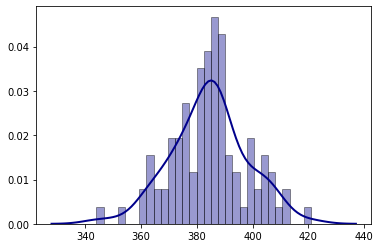

In [105]:
graph_knn = get_knntree(df,4)
graph_knn = add_node_attr(graph_knn, df)
mcec(graph_knn, df, 100)

In [87]:
ll =np.array([1,2,3,4,5,6,7])
ll[ll>3]

array([4, 5, 6, 7])

In [10]:

def get_gong(df, y=0):
    graph = nx.DiGraph() 
    graph.add_nodes_from(df.iterrows())
    dists = pdist(df[['x','y']]) 
    dists = squareform(dists)
    y_dists = (1-y)*dists
    
    for node_a, row_a in df.iterrows():
        node_a_coord = list(row_a[:2]) # O(dn)
        dist_idx = np.argsort(dists[node_a]) # O(nlog n)
        for node_b in dist_idx:
            if node_a == node_b:
                continue
                
            node_b_coord = list(df.loc[node_b, ['x','y']])

            d_i = y_dists[node_a][node_b]
            first_greater = bisect.bisect_left(dists[node_a][dist_idx], d_i)
            
            b_is_GONG = True

            for node_j in dist_idx[:first_greater]:
                if node_a == node_j:
                    continue
                    
                d_j = y_dists[node_a][node_j]
                
                if d_j < d_i:
                    b_is_GONG = False
                    break # node_j could be a GONG

            if b_is_GONG:
                graph.add_edge(node_a, node_b, weight = dists[node_a][node_b])
    return graph

In [15]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial.distance import  pdist, squareform
import bisect


get_gong(df, y=0)